<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2022/blob/main/notebooks/AML_2022_HandsOn_2_DnCNN_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning for Physics 2021-2022
## Hands-on session 2

Implementation in pytorch of a denoising CNN based on 1D convolutions and [residual learning](https://arxiv.org/abs/1512.03385), trained for the task of isolating the signal from spourious backgrounds in spectra from non-linear fast raman spectroscopy 

Based on a modified version of the DnCNN architecture ([K.Shang et al.](https://arxiv.org/abs/1608.03981)), modified for the new task and to work with one dimensional distributions

*Stefano Giagu - v1.0 - 18.2.2022*

In [178]:
# needed libaries: numpy, matpoltlib, sklearn, torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

1.10.0+cu111
0.11.1+cu111


In [179]:
# define device to use (cpu/gpu)
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

# of GPUs available:  1
First GPU type:  Tesla K80
Computation device: cuda



In [12]:
# download datasets
!wget http://giagu.web.cern.ch/giagu/CERN/FSRamanSpectra_simulationFumero.zip

--2022-02-18 13:18:30--  http://giagu.web.cern.ch/giagu/CERN/FSRamanSpectra_simulationFumero.zip
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 485975375 (463M) [application/zip]
Saving to: ‘FSRamanSpectra_simulationFumero.zip’

FSRamanSpectra_simu 100%[===================>] 463.46M  3.17MB/s    in 1m 47s  

2022-02-18 13:20:19 (4.34 MB/s) - ‘FSRamanSpectra_simulationFumero.zip’ saved [485975375/485975375]



In [13]:
!unzip FSRamanSpectra_simulationFumero.zip

# the zip file contains several examples of clean (ground truth) and  measured spectra 
# (LowNoise, MixedNoise, August17_MixedNoise (a different model of noise with larger statistics), HighNoise). 

# data is availabel as numpy tensors with shape:
# (5000,801): 5000 examples each one with 801 sampling of the fast raman distribution: LowNoise, MixedNoise, HighNoise
# (15000,801): 15000 examples for August17_MixedNoise

Archive:  FSRamanSpectra_simulationFumero.zip
   creating: FSRamanSpectra_simulationFumero/
  inflating: FSRamanSpectra_simulationFumero/Snoise_LowNoise.txt  
  inflating: FSRamanSpectra_simulationFumero/Snoise_HighNoise.txt  
  inflating: FSRamanSpectra_simulationFumero/Sclean_LowNoise.txt  
  inflating: FSRamanSpectra_simulationFumero/Sclean_MixedNoise.txt  
  inflating: FSRamanSpectra_simulationFumero/Sclean_August17_MixedNoise.txt  
  inflating: FSRamanSpectra_simulationFumero/Snoise_MixedNoise.txt  
  inflating: FSRamanSpectra_simulationFumero/Snoise_August17_MixedNoise.txt  
  inflating: FSRamanSpectra_simulationFumero/Sclean_HighNoise.txt  


spectrum shape:  (5000, 801)


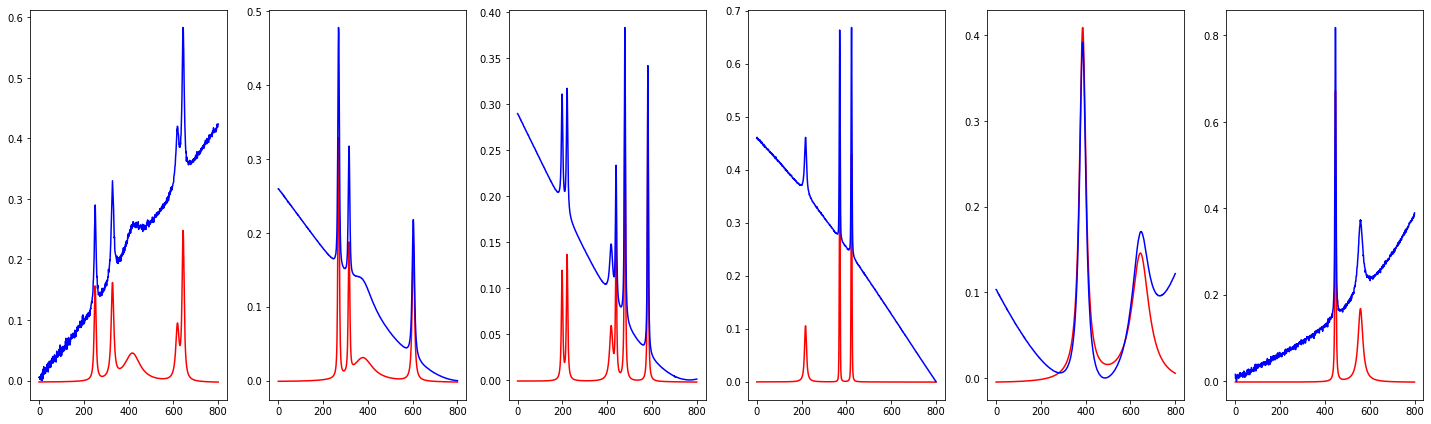

In [180]:
#read one of the datasets
# Let's use the low noise case
true = np.loadtxt('FSRamanSpectra_simulationFumero/Sclean_LowNoise.txt')
meas = np.loadtxt('FSRamanSpectra_simulationFumero/Snoise_LowNoise.txt')

true = true.transpose()
meas = meas.transpose()

print('spectrum shape: ', true.shape)

# normalize all measured spectra amplitudes so that minimum is zero 
for i in range(meas.shape[0]):
  max = meas[i].max()
  min = meas[i].min()
  if (max-min)>0:  
    meas[i] = (meas[i] - min)

#plot few examples
plt.figure(figsize=(20,6))

for idx in range(6):
    plt.subplot(1,6,idx+1)
    plt.plot(true[idx], '-r')
    plt.plot(meas[idx], '-b')

plt.tight_layout()
plt.draw()

In [181]:
# training, validation, test split
from sklearn.model_selection import train_test_split
testset_frac = 0.2 # test set fraction wrt whole samples
valiset_frac = 0.25 # validation set fraction wrt training+validation

X_train,X_test,Y_train,Y_test = train_test_split(meas,true,test_size=testset_frac, shuffle=True, random_state=1234)
X_train,X_vali,Y_train,Y_vali = train_test_split(X_train,Y_train,test_size=valiset_frac, shuffle=True, random_state=1234)

X_train = np.expand_dims(X_train, -1)
Y_train = np.expand_dims(Y_train, -1)
X_vali = np.expand_dims(X_vali, -1)
Y_vali = np.expand_dims(Y_vali, -1)
X_test = np.expand_dims(X_test, -1)
Y_test = np.expand_dims(Y_test, -1)

print('X_train shape: ',X_train.shape)
print('Y_train shape: ',Y_train.shape)
print('X_vali shape: ',X_vali.shape)
print('Y_vali shape: ',Y_vali.shape)
print('X_test shape: ',X_test.shape)
print('Y_test shape: ',Y_test.shape)

X_train shape:  (3000, 801, 1)
Y_train shape:  (3000, 801, 1)
X_vali shape:  (1000, 801, 1)
Y_vali shape:  (1000, 801, 1)
X_test shape:  (1000, 801, 1)
Y_test shape:  (1000, 801, 1)


In [182]:
# transform numpy vectors to pytorch tensors

X_train_pt = torch.Tensor(X_train)
Y_train_pt = torch.Tensor(Y_train)
X_vali_pt = torch.Tensor(X_vali)
Y_vali_pt = torch.Tensor(Y_vali)
X_test_pt = torch.Tensor(X_test)
Y_test_pt = torch.Tensor(Y_test)

# switch channel dimension position as needed by pytorch (NOTE: in numpy/keras (dim1,dim2,..., channels) in pytorch (channel, dim1, dim2, ...))

X_train_pt = X_train_pt.permute(0,2,1)
Y_train_pt = Y_train_pt.permute(0,2,1)
X_vali_pt = X_vali_pt.permute(0,2,1)
Y_vali_pt = Y_vali_pt.permute(0,2,1)
X_test_pt = X_test_pt.permute(0,2,1)
Y_test_pt = Y_test_pt.permute(0,2,1)

print(X_train_pt.shape)
print(Y_train_pt.shape)
print(X_vali_pt.shape)
print(Y_vali_pt.shape)
print(X_test_pt.shape)
print(Y_test_pt.shape)

torch.Size([3000, 1, 801])
torch.Size([3000, 1, 801])
torch.Size([1000, 1, 801])
torch.Size([1000, 1, 801])
torch.Size([1000, 1, 801])
torch.Size([1000, 1, 801])


In [184]:
# Definition of the ANN model: DnCNN 1 Dimensional
# as in the orginal paper: architecture conv1d + 15 x conv1d + BN + relu + conv1d output and residual layer
from torch import nn
import torch.nn.functional as F

# define the network by inerithing from nn.Module class
class DnCNN(nn.Module):
  def __init__(self, num_layers=15):
    super(DnCNN, self).__init__()
    self.num_layers=num_layers
  
    # define layers of the first block
    # 1D convolution (https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html)
    # input 1 channel --> output 64 channels (i.e. convolutional filters)
    self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=10, padding='same', bias=False)
    self.relu1 = nn.ReLU()

    # central blocks: num_layers blocks with conv1d + BN + relu activation
    hlayers = []
    for _ in range(num_layers):
      hlayers.append(nn.Conv1d(in_channels=64, out_channels=64, kernel_size=10, padding='same', bias=False))
      #hlayers.append(nn.BatchNorm1d(64))
      hlayers.append(nn.ReLU())

    self.central_block = nn.Sequential(*hlayers) 

    # output block: 64 channels --> 1 output channel (i.e. the original image)
    self.conv3 = nn.Conv1d(in_channels=64, out_channels=1, kernel_size=10, padding='same', bias=False)

  # forward pass: x (input) -> out  
  def forward(self, x):
    out = self.relu1(self.conv1(x))
    out = self.central_block(out)
    out = self.conv3(out)

    # residual learning (this way out become the clean spectrum and the network has only to learn the "noise")
    out = x - out
    return out

In [185]:
# instantiate the model
model = DnCNN(num_layers=15)
print(model)

# this is a useful tool to print the structure of the model in a keras-like fashion ... 
from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,801))
else:
  summary(model, input_size=(1,801))

DnCNN(
  (conv1): Conv1d(1, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
  (relu1): ReLU()
  (central_block): Sequential(
    (0): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
    (1): ReLU()
    (2): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
    (3): ReLU()
    (4): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
    (5): ReLU()
    (6): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
    (7): ReLU()
    (8): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
    (9): ReLU()
    (10): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
    (11): ReLU()
    (12): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
    (13): ReLU()
    (14): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, bias=False)
    (15): ReLU()
    (16): Conv1d(64, 64, kernel_size=(10,), stride=(1,), padding=same, 

In [189]:
# define loss function, monitoring metric and optmizer

#loss MSE
loss_func = nn.MSELoss()

#metric MAE (called L1Loss in pytorch)
metric_func = nn.L1Loss()

# optimizer: Adam
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-3)

# scheduler for step decay lr schedule
scheduler = optim.lr_scheduler.StepLR(opt, 10, gamma=0.1, last_epoch=-1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [190]:
# move the model into the GPU
model.to('cpu')
print('The model is in the: ', next(model.parameters()).device)
model.to(device)
print('now the model is in the: ', next(model.parameters()).device)

The model is in the:  cpu
now the model is in the:  cuda:0


In [191]:
#Checkpoints (to save model parameters during training)
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that 
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pth')

In [192]:
# training parameters

epochs = 20
batch_size = 32

# define dataloaders
from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(X_train_pt, Y_train_pt) 
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) 

dataset_vali = TensorDataset(X_vali_pt, Y_vali_pt) 
dataloader_vali = DataLoader(dataset_vali, batch_size=batch_size) 

In [193]:
#training loop

import time

save_best_model = SaveBestModel()

# lists to save loss and metric history
hist_loss = []
hist_metric = []
hist_vloss = []
hist_vmetric = []

#loop over epochs
for epoch in range(epochs):
    t0 = time.time()

    #training step
    model.train()

    train_loss = 0.0
    train_metric = 0.0
    counter = 0
    for xb, yb in dataloader_train: #takes a batch from the train dataloader 
        counter += 1 
        xb=xb.type(torch.float).to(device) #move troch tensors to device (cpu or GPU)
        yb=yb.type(torch.float).to(device)
        
        pred = model(xb) #get prediction for batch
        loss = loss_func(pred, yb) #compute loss
        metric = metric_func(pred, yb) #compute metric

        train_loss += loss.item() #update total loss
        train_metric += metric.item() #update total metric

        # backpropagation
        loss.backward()
        # update weights
        opt.step()
        # set to zero gradients for the next step
        opt.zero_grad()
 
    # normalize loss and metric by number of batches
    train_loss = train_loss/counter
    train_metric = train_metric/counter

    # update history
    hist_loss.append(train_loss)
    hist_metric.append(train_metric)


    # evaluation setp (same as trainign but w/o backpropagation)
    model.eval()

    vali_loss = 0.0
    vali_metric = 0.0
    counter = 0
    with torch.no_grad():
      for xb, yb in dataloader_vali:
        counter += 1
        xb=xb.type(torch.float).to(device)
        yb=yb.type(torch.float).to(device)
        pred = model(xb)
        vloss = loss_func(pred, yb)
        vmetric = metric_func(pred, yb)
        vali_loss += vloss.item()
        vali_metric += vmetric.item()
        
    vali_loss = vali_loss/counter
    vali_metric = vali_metric/counter    

    hist_vloss.append(vali_loss)
    hist_vmetric.append(vali_metric)

    #save best model
    save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)   

    elapsed_time = time.time()-t0
    print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))

    # update learning rate schedule
    scheduler.step()


Best validation loss: 0.0031494235518039204

Saving best model for epoch: 1

epoch: 1, time(s): 12.5072, train loss: 0.103543, train metric: 0.180018, vali loss: 0.003149, vali metric: 0.022866
Adjusting learning rate of group 0 to 1.0000e-03.

Best validation loss: 0.0007116911692719441

Saving best model for epoch: 2

epoch: 2, time(s): 12.3825, train loss: 0.001560, train metric: 0.018525, vali loss: 0.000712, vali metric: 0.013288
Adjusting learning rate of group 0 to 1.0000e-03.
epoch: 3, time(s): 12.3460, train loss: 0.001061, train metric: 0.017962, vali loss: 0.003078, vali metric: 0.038850
Adjusting learning rate of group 0 to 1.0000e-03.

Best validation loss: 0.0005596296814474044

Saving best model for epoch: 4

epoch: 4, time(s): 12.4161, train loss: 0.001052, train metric: 0.018706, vali loss: 0.000560, vali metric: 0.014309
Adjusting learning rate of group 0 to 1.0000e-03.

Best validation loss: 0.0004422426195560547

Saving best model for epoch: 5

epoch: 5, time(s): 1

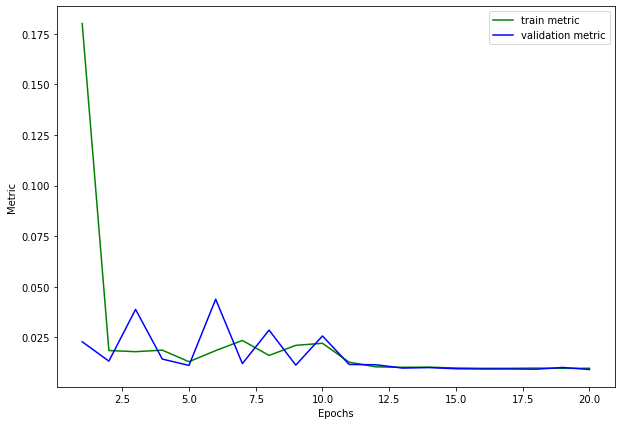

In [194]:
# plot metric (MAE) history

plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

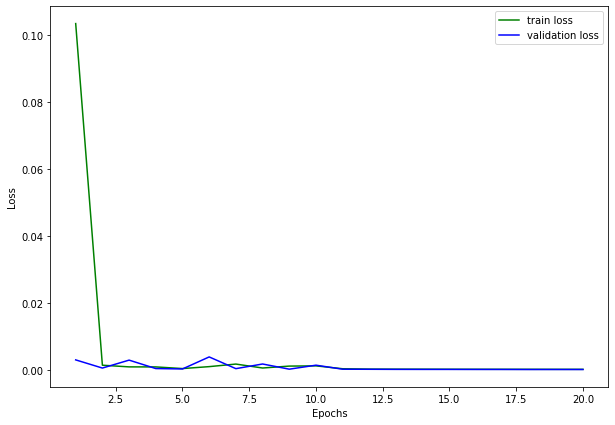

In [195]:
# plot loss (MSE) history

plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1),hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [196]:
#test

# load the best model checkpoint
best_model = torch.load('best_model.pth')
best_model_epoch = best_model['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")


model = DnCNN()
model.load_state_dict(best_model['model_state_dict'])

#let's do this on cpu (inference is fast)
model.to(torch.device('cpu'))

# test 10 cases
X_test_pt = X_test_pt[:10].type(torch.float).to(torch.device('cpu'))
prediction = model(X_test_pt)

Best model was saved at 20 epochs



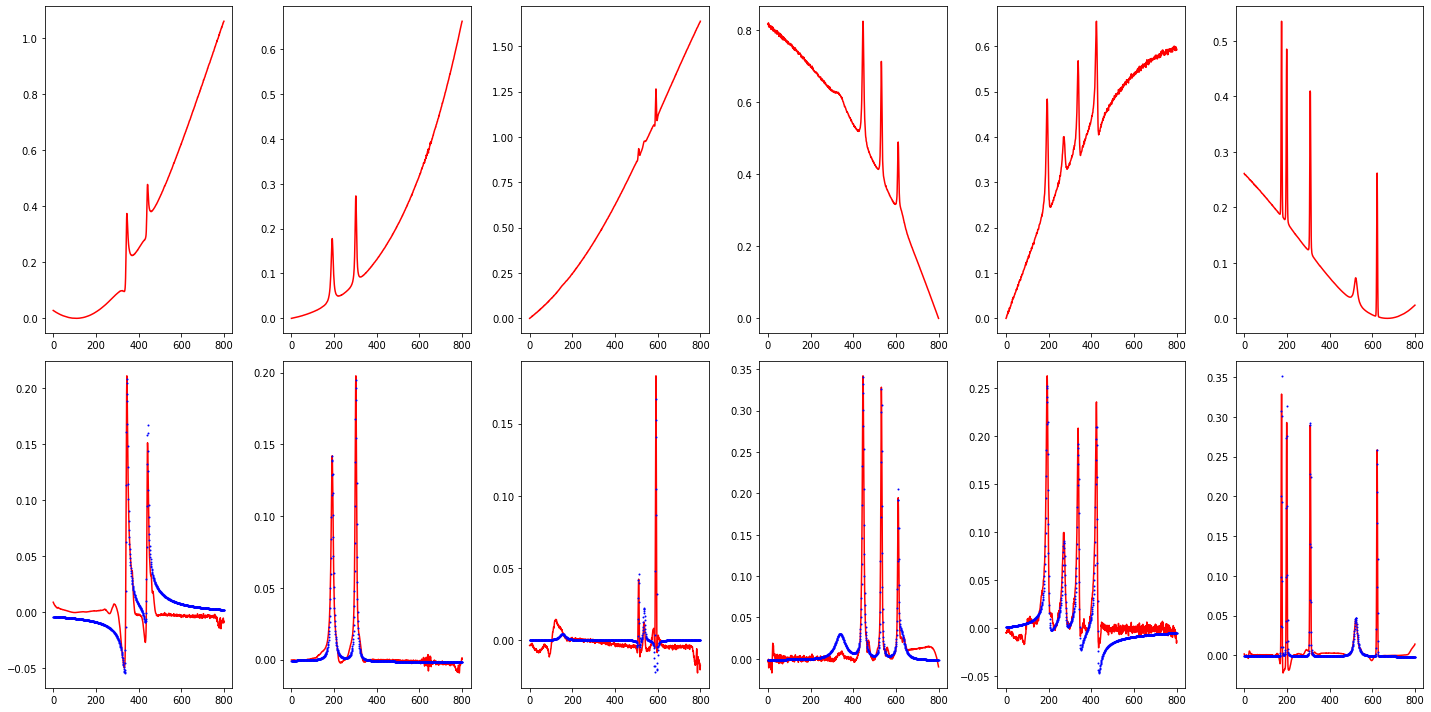

In [197]:
#plot results
shift=0
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(2,6,i+1)
    plt.plot(X_test_pt[i+shift].permute(1,0).numpy().reshape(801,), '-r') #input noisy spectrum
    plt.subplot(2,6,i+7)
    plt.plot(prediction[i+shift].permute(1,0).detach().numpy().reshape(801,), '-r') #cleaned spectrum predicted by te model
    plt.plot(Y_test_pt[i+shift].permute(1,0).numpy().reshape(801,), 'ob', markersize=1) #ground truth
plt.tight_layout()    

**spunti per sperimentare**

*   test model variations: with and w/o BN, try theusing dilated convolutions ([dilation](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) parameter), try to analyise in parallel the input with different kernels:


```
# code snippet example
self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=20, padding='same', bias=False)
    self.relu1 = nn.ReLU()

hlayers = []
for _ in range(num_layers):
  hlayers.append(nn.Conv1d(in_channels=64, out_channels=64, kernel_size=20, padding='same', bias=False))
  hlayers.append(nn.ReLU())

self.central_block = nn.Sequential(*hlayers) 

self.conv1_b = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, padding='same', bias=False)
    self.relu1_b = nn.ReLU()

hlayers_b = []
for _ in range(num_layers):
  hlayers_b.append(nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5, padding='same', bias=False))
  hlayers_b.append(nn.ReLU())

self.central_block_b = nn.Sequential(*hlayers_b)

self.conv3 = nn.Conv1d(in_channels=64*2, out_channels=1, kernel_size=1, padding='same', bias=False)

def forward(self, x):
    out = self.relu1(self.conv1(x))
    out = self.central_block(out)

    out_b = self.relu1_b(self.conv1_b(x))
    out_b = self.central_block_b(out_b)
                             
    out = torch.cat((out,out_b), dim=1)
    out = self.conv3(out)

    # residual learning (this way out become the clean spectrum and the network has only to learn the "noise")
    out = x - out
    return out
```



*   test medium and high noise cases ...

